# Load modules and dataset

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import datetime

In [2]:
train_path = '../../../data/mind_news/mind_small_train/'
train_news = pd.read_csv(train_path + 'news.tsv', header=None ,sep='\t')
train_behaviors = pd.read_csv(train_path + 'behaviors.tsv', header=None, sep='\t')

valid_path = '../../../data/mind_news/mind_small_dev/'
valid_news = pd.read_csv(valid_path + 'news.tsv', header=None, sep='\t')
valid_behaviors = pd.read_csv(valid_path + 'behaviors.tsv', header=None, sep='\t')

In [3]:
news_cols = ['news_id','category','subcategory','title','abstract','url',
             'title_entities','abstract_entities']
behavior_cols = ['impression_id','user_id','time','click_history','impression']

train_news.columns = news_cols
valid_news.columns = news_cols
train_behaviors.columns = behavior_cols
valid_behaviors.columns = behavior_cols

# EDA

In [4]:
train_behaviors.head(3)
# impression_id, click_history -> remove
# time -> Reshape Unix epoch format
# impression -> 1이면 클릭, 0이면 non-click, news_id_1|news_id_2| 이런 형태로 바꿔야 함

impression_id user_id                   time  \
0              1  U13740  11/11/2019 9:05:58 AM   
1              2  U91836  11/12/2019 6:11:30 PM   
2              3  U73700  11/14/2019 7:01:48 AM   

                                       click_history  \
0  N55189 N42782 N34694 N45794 N18445 N63302 N104...   
1  N31739 N6072 N63045 N23979 N35656 N43353 N8129...   
2  N10732 N25792 N7563 N21087 N41087 N5445 N60384...   

                                          impression  
0                                  N55689-1 N35729-0  
1  N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...  
2  N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...

In [5]:
train_behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   impression_id  156965 non-null  int64 
 1   user_id        156965 non-null  object
 2   time           156965 non-null  object
 3   click_history  153727 non-null  object
 4   impression     156965 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [6]:
train_news.head(3)
# news_id, category, subcategory, title 남기기

news_id   category      subcategory  \
0  N55528  lifestyle  lifestyleroyals   
1  N19639     health       weightloss   
2  N61837       news        newsworld   

                                               title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1                      50 Worst Habits For Belly Fat   
2  The Cost of Trump's Aid Freeze in the Trenches...   

                                            abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  These seemingly harmless habits are holding yo...   
2  Lt. Ivan Molchanets peeked over a parapet of s...   

                                             url  \
0  https://assets.msn.com/labs/mind/AAGH0ET.html   
1  https://assets.msn.com/labs/mind/AAB19MK.html   
2  https://assets.msn.com/labs/mind/AAJgNsz.html   

                                      title_entities  \
0  [{"Label": "Prince Philip, Duke of Edinburgh",...   
1  [{"Label": "Adipose tissue", "Type": "C", "Wik...   
2                                                 []   

                                   abstract_entities  
0                                                 []  
1  [{"Label": "Adipose tissue", "Type": "C", "Wik...  
2  [{"Label": "Ukraine", "Type": "G", "WikidataId...

In [7]:
train_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   news_id            51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [8]:
# user 방문빈도 : 5만 유저, 5만 아이템, 15만 인터랙션
train_behaviors['user_id'].count()
train_behaviors['user_id'].value_counts()

U32146    62
U15740    44
U20833    41
U44201    40
U51286    40
          ..
U22531     1
U25026     1
U13886     1
U15584     1
U40799     1
Name: user_id, Length: 50000, dtype: int64

<AxesSubplot:ylabel='Frequency'>

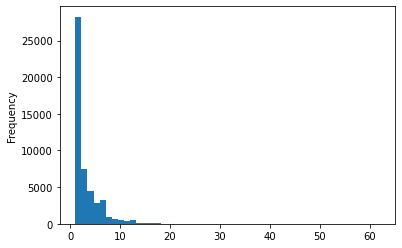

In [9]:
# user 방문빈도 histogram
train_behaviors['user_id'].value_counts().plot(kind='hist', bins=50)

In [10]:
# 모든 row에 click이 발생했는지 확인 
train_behaviors['impression'].str.contains('1').count() 

156965

# item_df 전처리

In [11]:
# 필요한 컬럼만 남김
train_news = train_news.iloc[:,:4]
valid_news = valid_news.iloc[:,:4]

In [12]:
train_news.columns

Index(['news_id', 'category', 'subcategory', 'title'], dtype='object')

In [13]:
train_items_df = train_news.rename(columns = {'news_id':'ITEM_ID',
                                              'category':'CATEGORY',
                                              'subcategory':'SUBCATEGORY',
                                              'title':'TITLE'})
valid_items_df = valid_news.rename(columns = {'news_id':'ITEM_ID',
                                              'category':'CATEGORY',
                                              'subcategory':'SUBCATEGORY',
                                              'title':'TITLE'})

In [14]:
train_items_df.head(3)

ITEM_ID   CATEGORY      SUBCATEGORY  \
0  N55528  lifestyle  lifestyleroyals   
1  N19639     health       weightloss   
2  N61837       news        newsworld   

                                               TITLE  
0  The Brands Queen Elizabeth, Prince Charles, an...  
1                      50 Worst Habits For Belly Fat  
2  The Cost of Trump's Aid Freeze in the Trenches...

In [15]:
train_items_df = train_items_df.astype('string')
valid_items_df = valid_items_df.astype('string')

In [16]:
# save as csv file
train_items_df.to_csv('../../../data/mind_news/processed/train_items_df.csv', index=False)
valid_items_df.to_csv('../../../data/mind_news/processed/valid_items_df.csv', index=False)

# interaction_df 전처리

In [17]:
train_behaviors.columns

Index(['impression_id', 'user_id', 'time', 'click_history', 'impression'], dtype='object')

In [18]:
# 필요한 컬럼만 남김
train_behaviors = train_behaviors.drop(['impression_id','click_history'], axis=1)
valid_behaviors = valid_behaviors.drop(['impression_id','click_history'], axis=1)
train_behaviors.head(2)

user_id                   time  \
0  U13740  11/11/2019 9:05:58 AM   
1  U91836  11/12/2019 6:11:30 PM   

                                          impression  
0                                  N55689-1 N35729-0  
1  N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...

In [19]:
## time 포맷 변경 : string => UTC => timestamp(Unix epoch)
# train_behaviors.loc[train_behaviors['time'].str.contains('PM')].head(3)
train_behaviors['time'] = train_behaviors['time'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p').timestamp())
valid_behaviors['time'] = valid_behaviors['time'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p').timestamp())
train_behaviors.head()

user_id          time                                         impression
0  U13740  1.573431e+09                                  N55689-1 N35729-0
1  U91836  1.573550e+09  N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2  U73700  1.573683e+09  N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3  U34670  1.573418e+09                N35729-0 N33632-0 N49685-1 N27581-0
4   U8125  1.573543e+09  N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...

In [20]:
# clicked item 추출 : 'item_id'
train_behaviors['item_id'] = train_behaviors['impression'].str.split('-1',expand=True)[0].str[-6:]
valid_behaviors['item_id'] = valid_behaviors['impression'].str.split('-1',expand=True)[0].str[-6:]
train_behaviors.head(3)

user_id          time                                         impression  \
0  U13740  1.573431e+09                                  N55689-1 N35729-0   
1  U91836  1.573550e+09  N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...   
2  U73700  1.573683e+09  N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...   

  item_id  
0  N55689  
1  N17059  
2  N23814

In [21]:
train_behaviors

user_id          time  \
0       U13740  1.573431e+09   
1       U91836  1.573550e+09   
2       U73700  1.573683e+09   
3       U34670  1.573418e+09   
4        U8125  1.573543e+09   
...        ...           ...   
156960  U21593  1.573738e+09   
156961  U10123  1.573596e+09   
156962  U75630  1.573697e+09   
156963  U44625  1.573625e+09   
156964  U64800  1.573713e+09   

                                               impression item_id  
0                                       N55689-1 N35729-0  N55689  
1       N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...  N17059  
2       N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...  N23814  
3                     N35729-0 N33632-0 N49685-1 N27581-0  N49685  
4       N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...   N8400  
...                                                   ...     ...  
156960  N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...  N50055  
156961  N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...  N30212  
156962  N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...  N46283  
156963  N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...  N21712  
156964                N61233-0 N33828-1 N19661-0 N41934-0  N33828  

[156965 rows x 4 columns]

In [22]:
# impression 포맷 변경 (| pipe 기호로 연결하기)
train_behaviors['impression'] = train_behaviors['impression'].str.replace('-1','|')
train_behaviors['impression'] = train_behaviors['impression'].str.replace('-0','|')
train_behaviors['impression'] = train_behaviors['impression'].str.replace(' ','')
train_behaviors['impression'] = train_behaviors['impression'].str[:-1]

valid_behaviors['impression'] = valid_behaviors['impression'].str.replace('-1','|')
valid_behaviors['impression'] = valid_behaviors['impression'].str.replace('-0','|')
valid_behaviors['impression'] = valid_behaviors['impression'].str.replace(' ','')
valid_behaviors['impression'] = valid_behaviors['impression'].str[:-1]

train_behaviors.head(10)

user_id          time                                         impression  \
0  U13740  1.573431e+09                                      N55689|N35729   
1  U91836  1.573550e+09  N20678|N39317|N58114|N20495|N42977|N22407|N145...   
2  U73700  1.573683e+09  N50014|N23877|N35389|N49712|N16844|N59685|N238...   
3  U34670  1.573418e+09                        N35729|N33632|N49685|N27581   
4   U8125  1.573543e+09  N39985|N36050|N16096|N8400|N22407|N60408|N6149...   
5  U19739  1.573466e+09                  N21119|N53696|N33619|N25722|N2869   
6   U8355  1.573443e+09  N51346|N33848|N15132|N10688|N6342|N61359|N7809...   
7  U46596  1.573565e+09    N7821|N24898|N12029|N13579|N42977|N33885|N11087   
8  U79199  1.573608e+09                        N51048|N64094|N13907|N39010   
9  U53231  1.573439e+09                                      N53585|N55689   

  item_id  
0  N55689  
1  N17059  
2  N23814  
3  N49685  
4   N8400  
5  N21119  
6  N55204  
7  N33885  
8  N51048  
9  N53585

<AxesSubplot:ylabel='Frequency'>

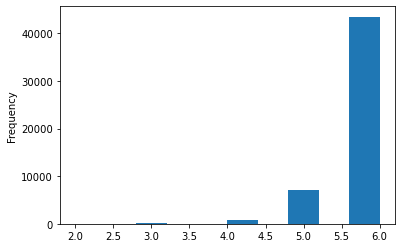

In [23]:
# news_id 문자열 길이가 3~6임 : 정리 필요
train_news['news_id'].apply(lambda x: len(x)).plot(kind='hist')

In [24]:
display(train_news[train_news['news_id'].apply(lambda x: len(x))<6].sample(3))
len(train_news[train_news['news_id'].apply(lambda x: len(x))<6])

news_id category   subcategory  \
24214   N6326   sports  football_nfl   
33681   N2967    autos     autosnews   
6720    N3170   sports  football_nfl   

                                                   title  
24214  Falcons fans bought tickets, didn't show up or...  
33681  Philly friends of Leo Beebe say 'Ford v Ferrar...  
6720   Chiefs announce quarterback Patrick Mahomes wi...

7799

In [25]:
train_behaviors['item_id'] = 'N'+train_behaviors['item_id'].str.split('N',expand=True)[1]
valid_behaviors['item_id'] = 'N'+valid_behaviors['item_id'].str.split('N',expand=True)[1]
train_behaviors.head()

user_id          time                                         impression  \
0  U13740  1.573431e+09                                      N55689|N35729   
1  U91836  1.573550e+09  N20678|N39317|N58114|N20495|N42977|N22407|N145...   
2  U73700  1.573683e+09  N50014|N23877|N35389|N49712|N16844|N59685|N238...   
3  U34670  1.573418e+09                        N35729|N33632|N49685|N27581   
4   U8125  1.573543e+09  N39985|N36050|N16096|N8400|N22407|N60408|N6149...   

  item_id  
0  N55689  
1  N17059  
2  N23814  
3  N49685  
4   N8400

In [26]:
valid_behaviors.head()

user_id          time                                         impression  \
0  U80234  1.573789e+09  N28682|N48740|N31958|N34130|N6916|N5472|N50775...   
1  U60458  1.573770e+09   N20036|N23513|N32536|N46976|N35216|N36779|N31958   
2  U44190  1.573779e+09  N36779|N62365|N58098|N5472|N13408|N55036|N1999...   
3  U87380  1.573798e+09  N6950|N60215|N6074|N11930|N6916|N24802|N48740|...   
4   U9444  1.573774e+09  N5940|N23513|N49285|N23355|N19990|N31958|N2939...   

  item_id  
0  N31958  
1  N23513  
2   N5940  
3  N15347  
4   N5940

In [27]:
train_behaviors.columns

Index(['user_id', 'time', 'impression', 'item_id'], dtype='object')

In [28]:
# EVENT_TYPE 추가
train_behaviors['EVENT_TYPE'] = 'click'
valid_behaviors['EVENT_TYPE'] = 'click'
train_behaviors.head(3)

user_id          time                                         impression  \
0  U13740  1.573431e+09                                      N55689|N35729   
1  U91836  1.573550e+09  N20678|N39317|N58114|N20495|N42977|N22407|N145...   
2  U73700  1.573683e+09  N50014|N23877|N35389|N49712|N16844|N59685|N238...   

  item_id EVENT_TYPE  
0  N55689      click  
1  N17059      click  
2  N23814      click

In [29]:
# Rename the column headers to a more standard naming convention for AWS Personalize import job
train_interactions_df = train_behaviors.rename(columns = {'user_id':'USER_ID',
                                                          'item_id':'ITEM_ID',
                                                          'time':'TIMESTAMP',
                                                          'impression':'IMPRESSION'})

valid_interactions_df = valid_behaviors.rename(columns = {'user_id':'USER_ID',
                                                          'item_id':'ITEM_ID',
                                                          'time':'TIMESTAMP',
                                                          'impression':'IMPRESSION'})
train_interactions_df.head(3)

USER_ID     TIMESTAMP                                         IMPRESSION  \
0  U13740  1.573431e+09                                      N55689|N35729   
1  U91836  1.573550e+09  N20678|N39317|N58114|N20495|N42977|N22407|N145...   
2  U73700  1.573683e+09  N50014|N23877|N35389|N49712|N16844|N59685|N238...   

  ITEM_ID EVENT_TYPE  
0  N55689      click  
1  N17059      click  
2  N23814      click

In [30]:
# Change timestamp data type as int
train_interactions_df = train_interactions_df.astype({'USER_ID':'string',
                                                    'IMPRESSION':'string',
                                                    'ITEM_ID':'string',
                                                    'TIMESTAMP': 'int64',
                                                    'EVENT_TYPE':'string'})

valid_interactions_df = valid_interactions_df.astype({'USER_ID':'string',
                                                    'IMPRESSION':'string',
                                                    'ITEM_ID':'string',
                                                    'TIMESTAMP': 'int64',
                                                    'EVENT_TYPE':'string'})

train_interactions_df.dtypes

USER_ID       string
TIMESTAMP      int64
IMPRESSION    string
ITEM_ID       string
EVENT_TYPE    string
dtype: object

In [31]:
train_interactions_df.to_csv('../../../data/mind_news/processed/train_interactions_df.csv', index=False)
valid_interactions_df.to_csv('../../../data/mind_news/processed/valid_interactions_df.csv', index=False)